In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn

from sklearn import tree
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import ListedColormap

## Деревья решений

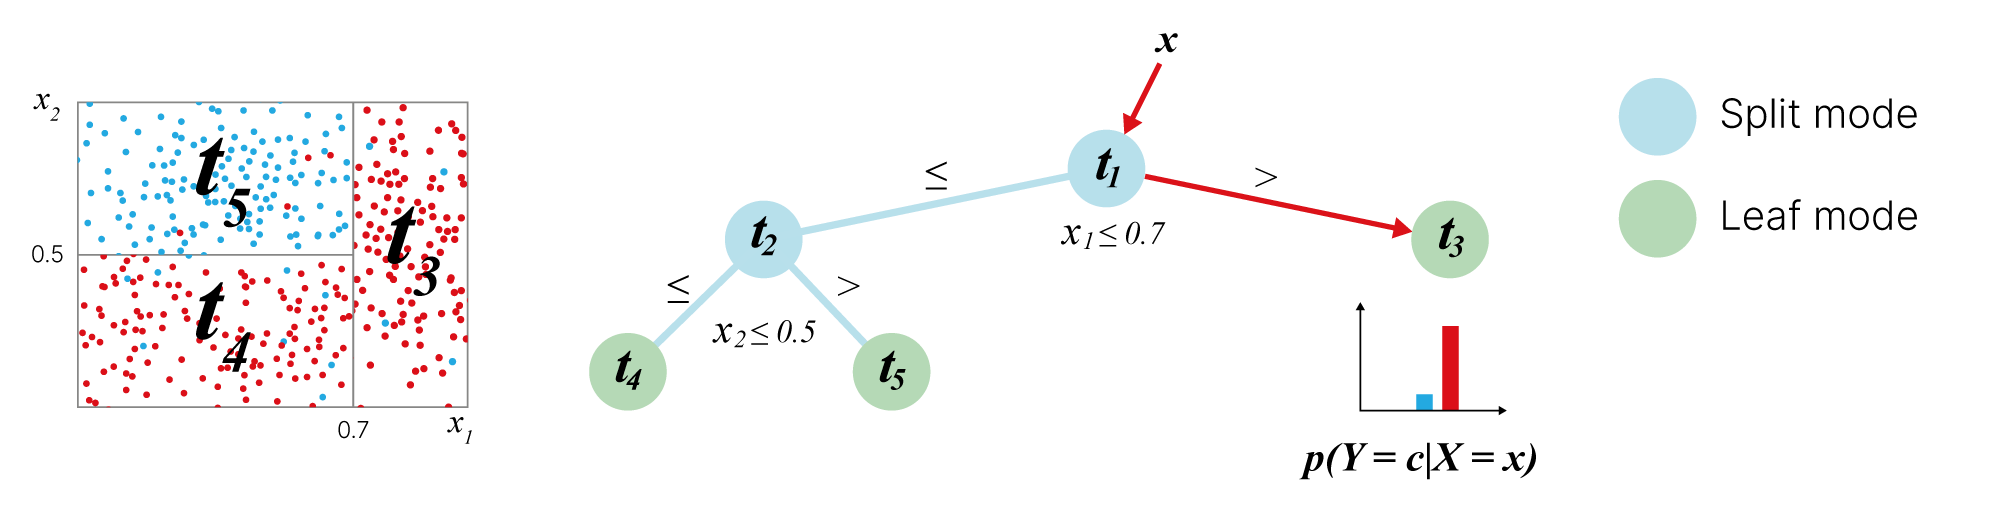

Выбираем самое "хорошее" разбиение, исходя из какой-то метрики. Одна из основных называется $Gini$:

$$Gini = 1 - \sum_ip_i^2$$

Фактически, она показывает, какова вероятность того, что два объекта, попавшие в один узел, принадлежат разным классам. Соответственно, чем она ниже, тем лучше получившийся узел.

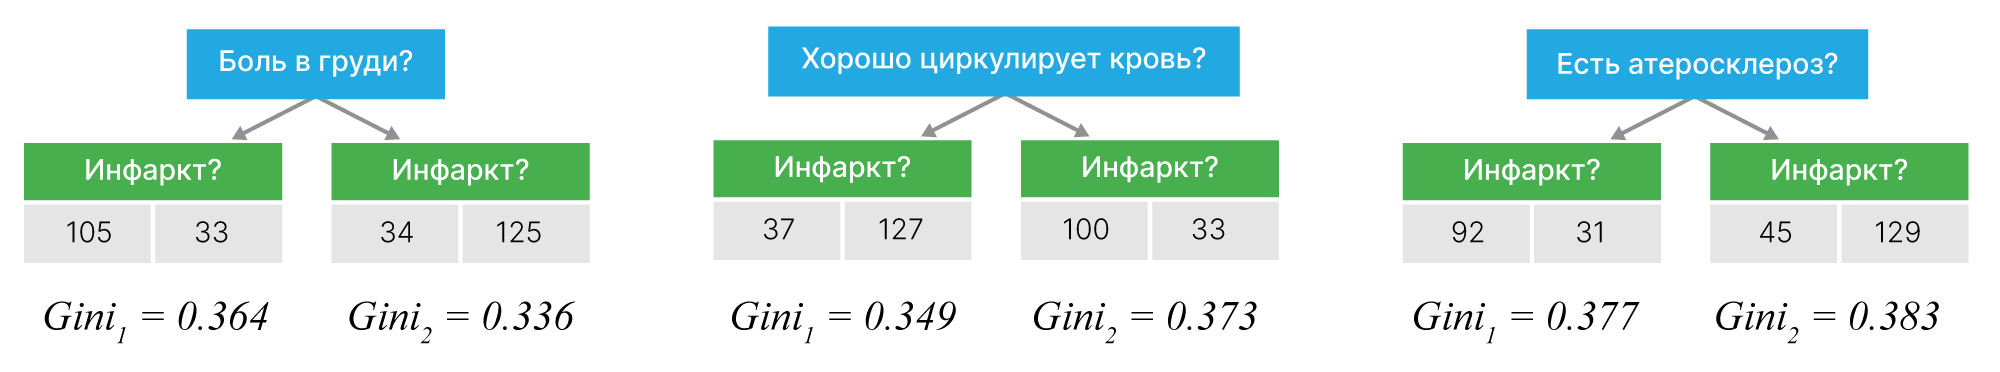

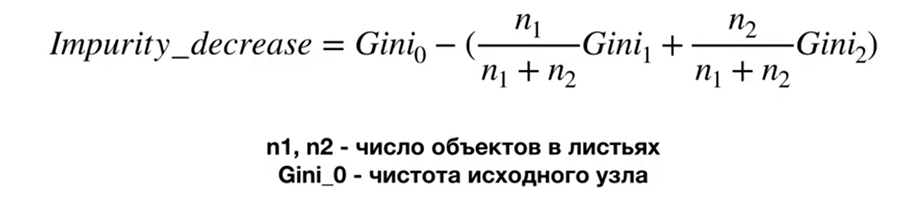

Исходно имеем:

* 139 человек с инфарктом
* 158 здоровых
* Всего 297

Посчитаем изначальное значение $Gini_0$:

In [2]:
p0 = 139 / 297
p1 = 158 / 297
gini_0 = 1 - np.sum(np.power([p0, p1], 2))
print(f"Gini_0 is: {gini_0:.3f}")

Gini_0 is: 0.498


Impurity decrease для первого сплита:

In [3]:
imp_dec_1 = gini_0 - (138 / 297 * 0.364 + 159 / 297 * 0.336)
print(f"Impurity decrease for 1st feature: {imp_dec_1:.3f}")

Impurity decrease for 1st feature: 0.149


Impurity decrease для второго сплита:

In [4]:
imp_dec_2 = gini_0 - (164 / 297 * 0.349 + 133 / 297 * 0.373)
print(f"Impurity decrease for 2nd feature: {imp_dec_2:.3f}")

Impurity decrease for 2nd feature: 0.138


Impurity decrease для третьего сплита:

In [5]:
imp_dec_3 = gini_0 - (123 / 297 * 0.377 + 174 / 297 * 0.383)
print(f"Impurity decrease for 3rd feature: {imp_dec_3:.3f}")

Impurity decrease for 3rd feature: 0.117


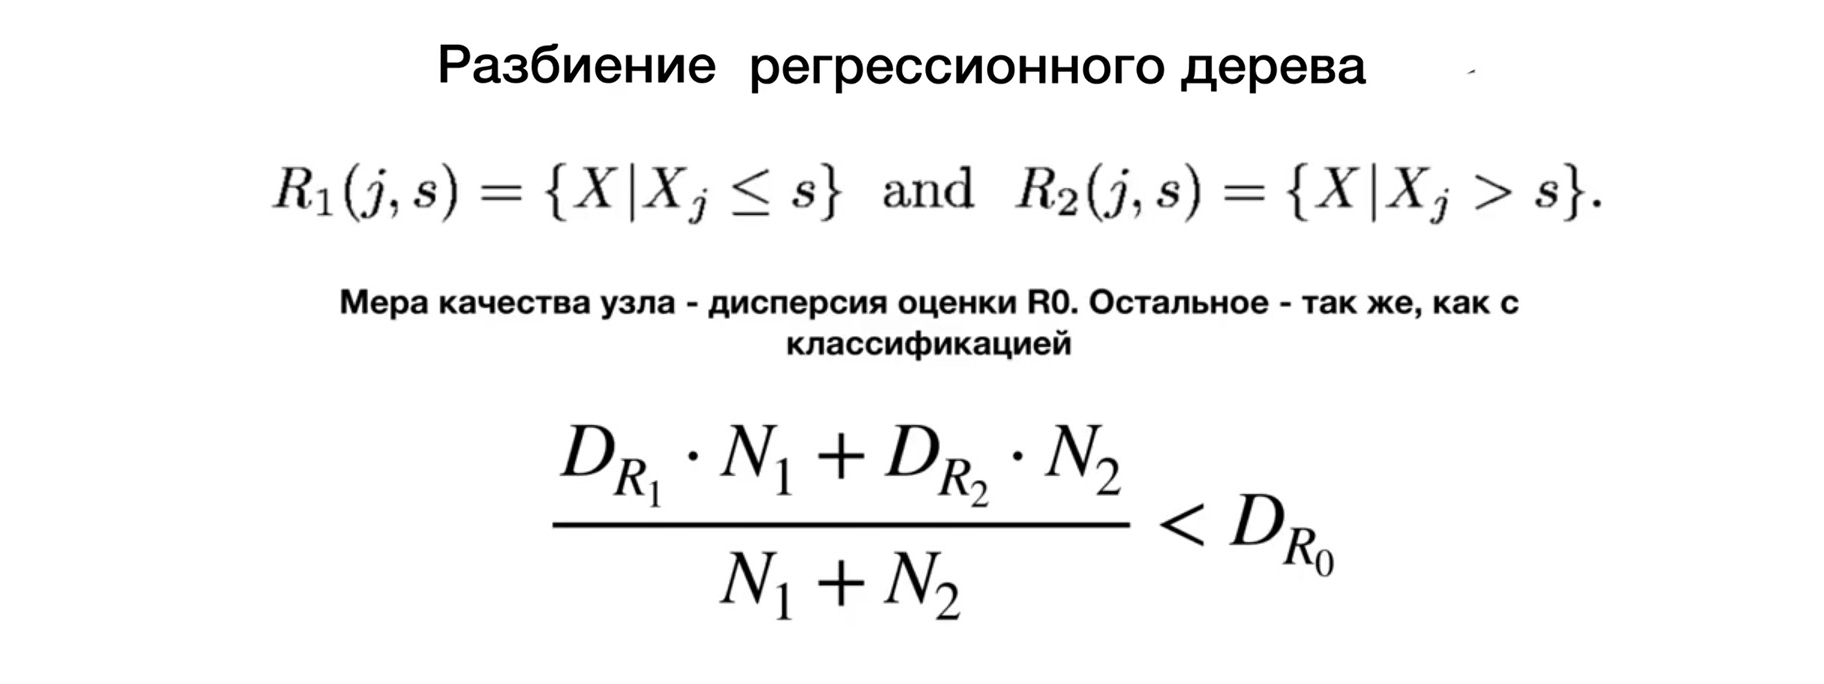

## Неустойчивость деревьев решений

In [6]:
data = load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)

# Сделаем классифиацию бинарной
df["target"] = data.target != 1 # 0 for setosa, 1 - versicolor, 2 - virginica

Сделаем два разных разбиения на обучение и тест. И посмотрим, будут ли отличаться деревья, построенные для данных разбиений.

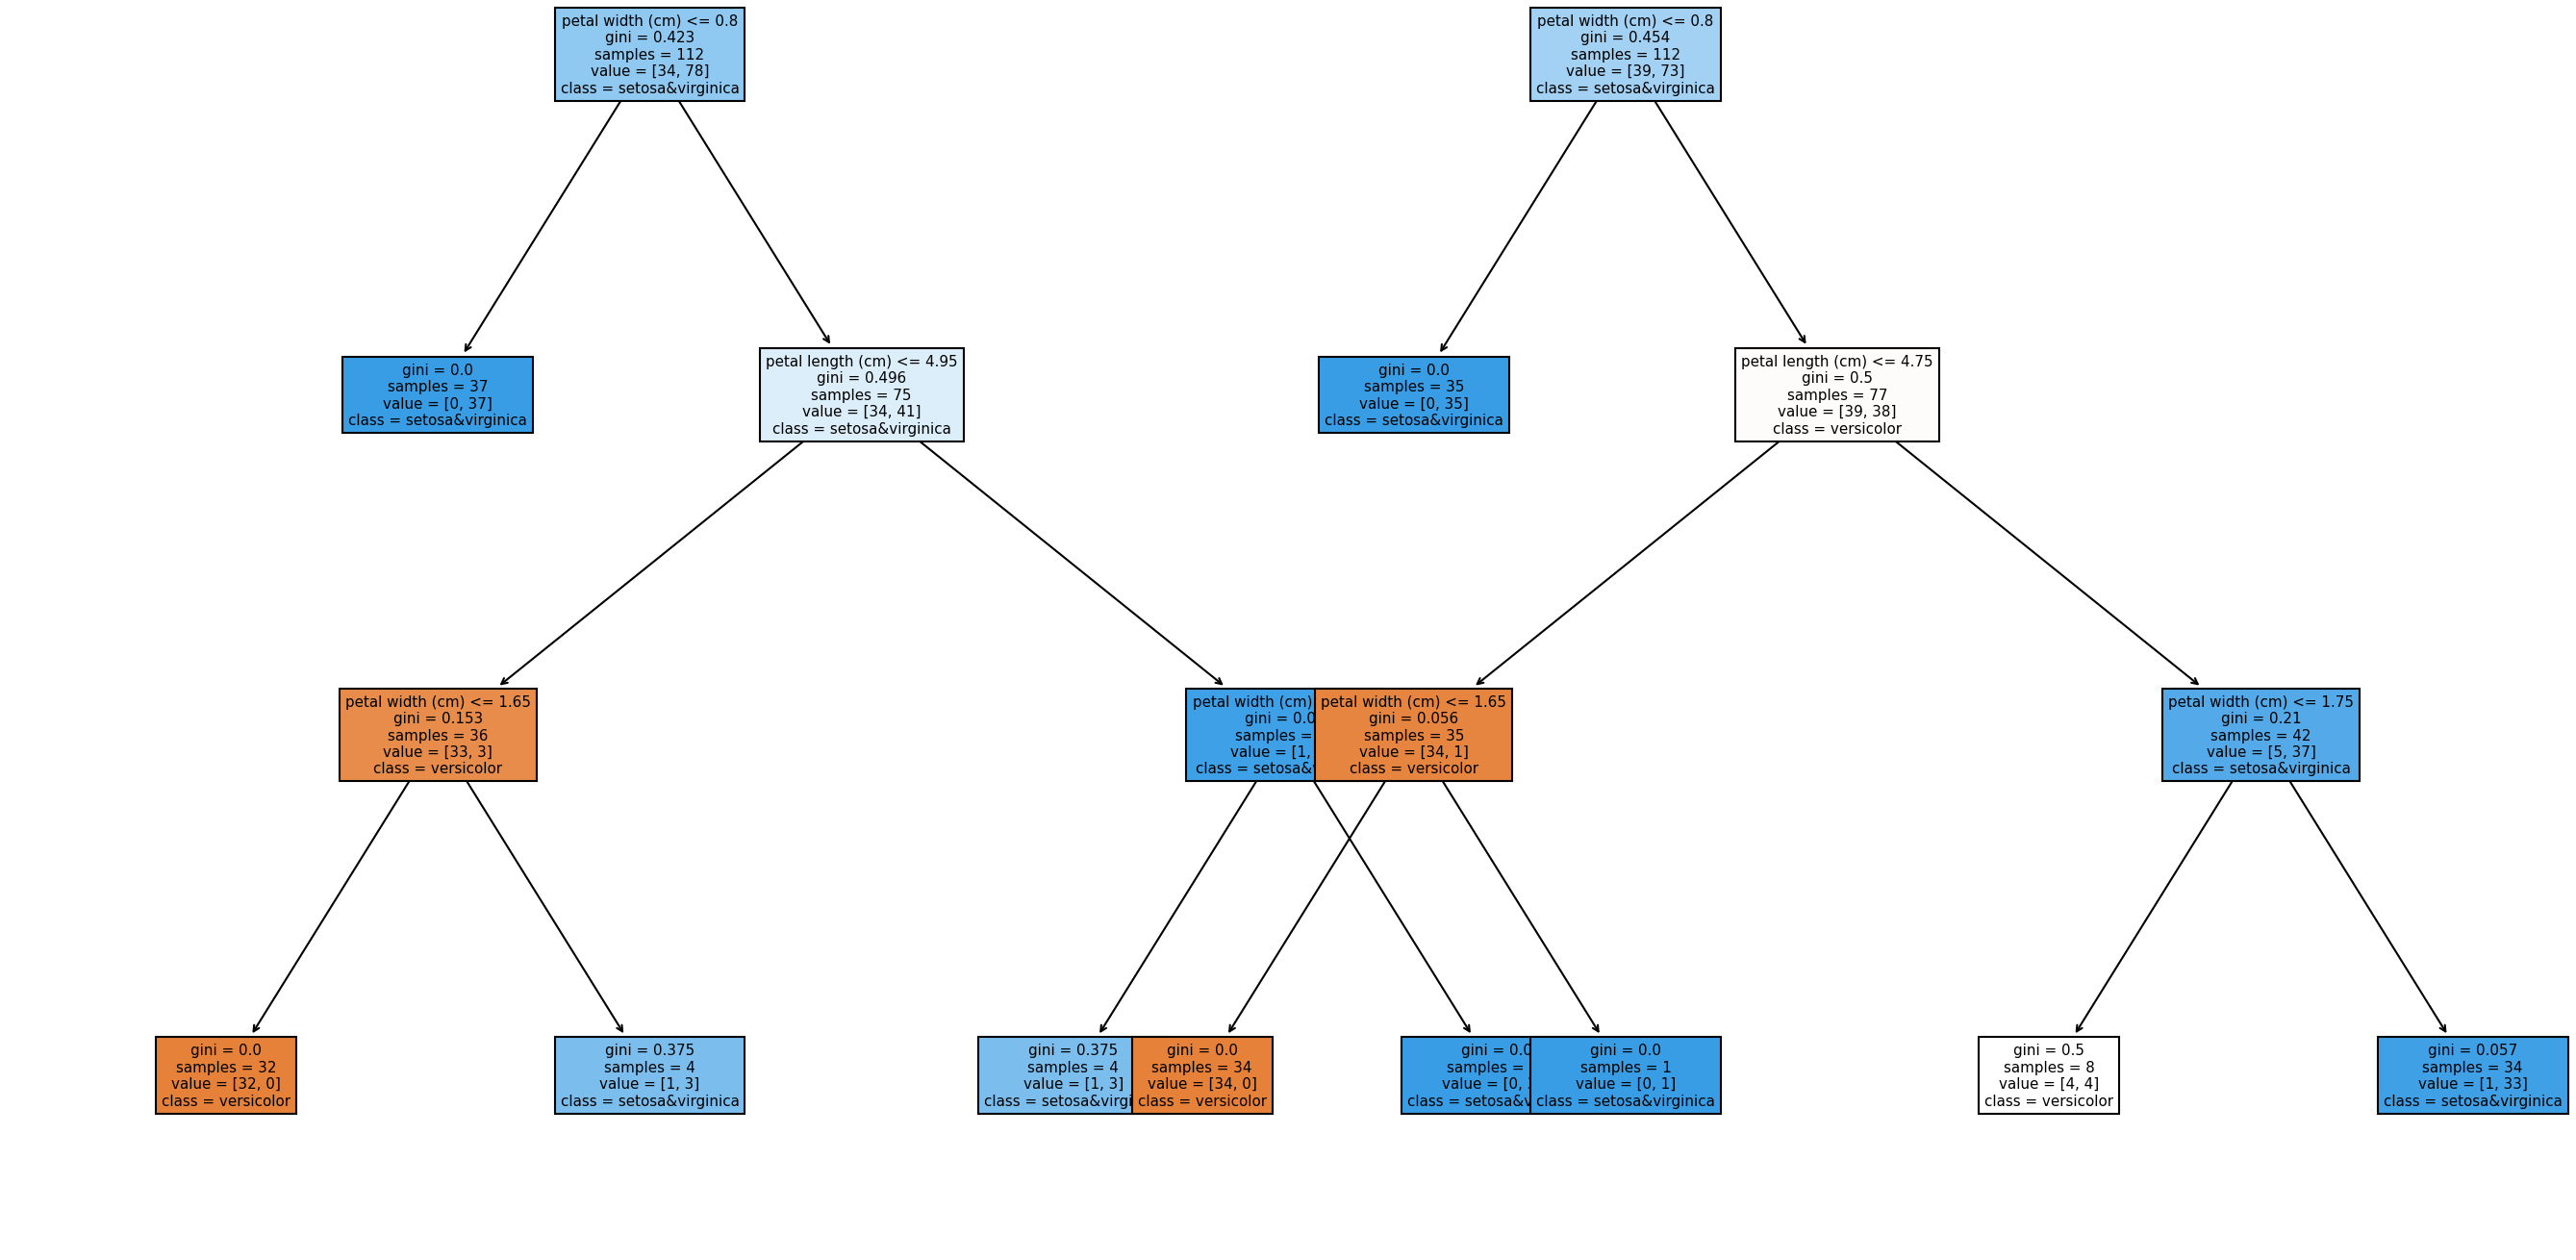

In [7]:
# первый набор точек
X_train1, X_test1, y_train1, y_test1 = train_test_split(df[data.feature_names], df["target"], 
                                                        random_state=0)
clf1 = DecisionTreeClassifier(max_depth=3)
clf1.fit(X_train1, y_train1)

# второй набор точек 
X_train2, X_test2, y_train2, y_test2 = train_test_split(df[data.feature_names], df["target"],
                                                        random_state=42)
clf2 = DecisionTreeClassifier(max_depth=3)
clf2.fit(X_train2, y_train2)


fn = ["sepal length (cm)", "sepal width (cm)",
      "petal length (cm)", "petal width (cm)"]

cn = ["versicolor", "setosa&virginica"]

fig, axes = plt.subplots(nrows=1, ncols=2, 
                         figsize=(16, 6), dpi=150)
tree.plot_tree(clf1,
               feature_names=fn,
               class_names=cn,
               filled=True, ax=axes[0])

tree.plot_tree(clf2,
               feature_names=fn,
               class_names=cn,
               filled=True, ax=axes[1])
plt.show()

А если взять деревья поглубже:

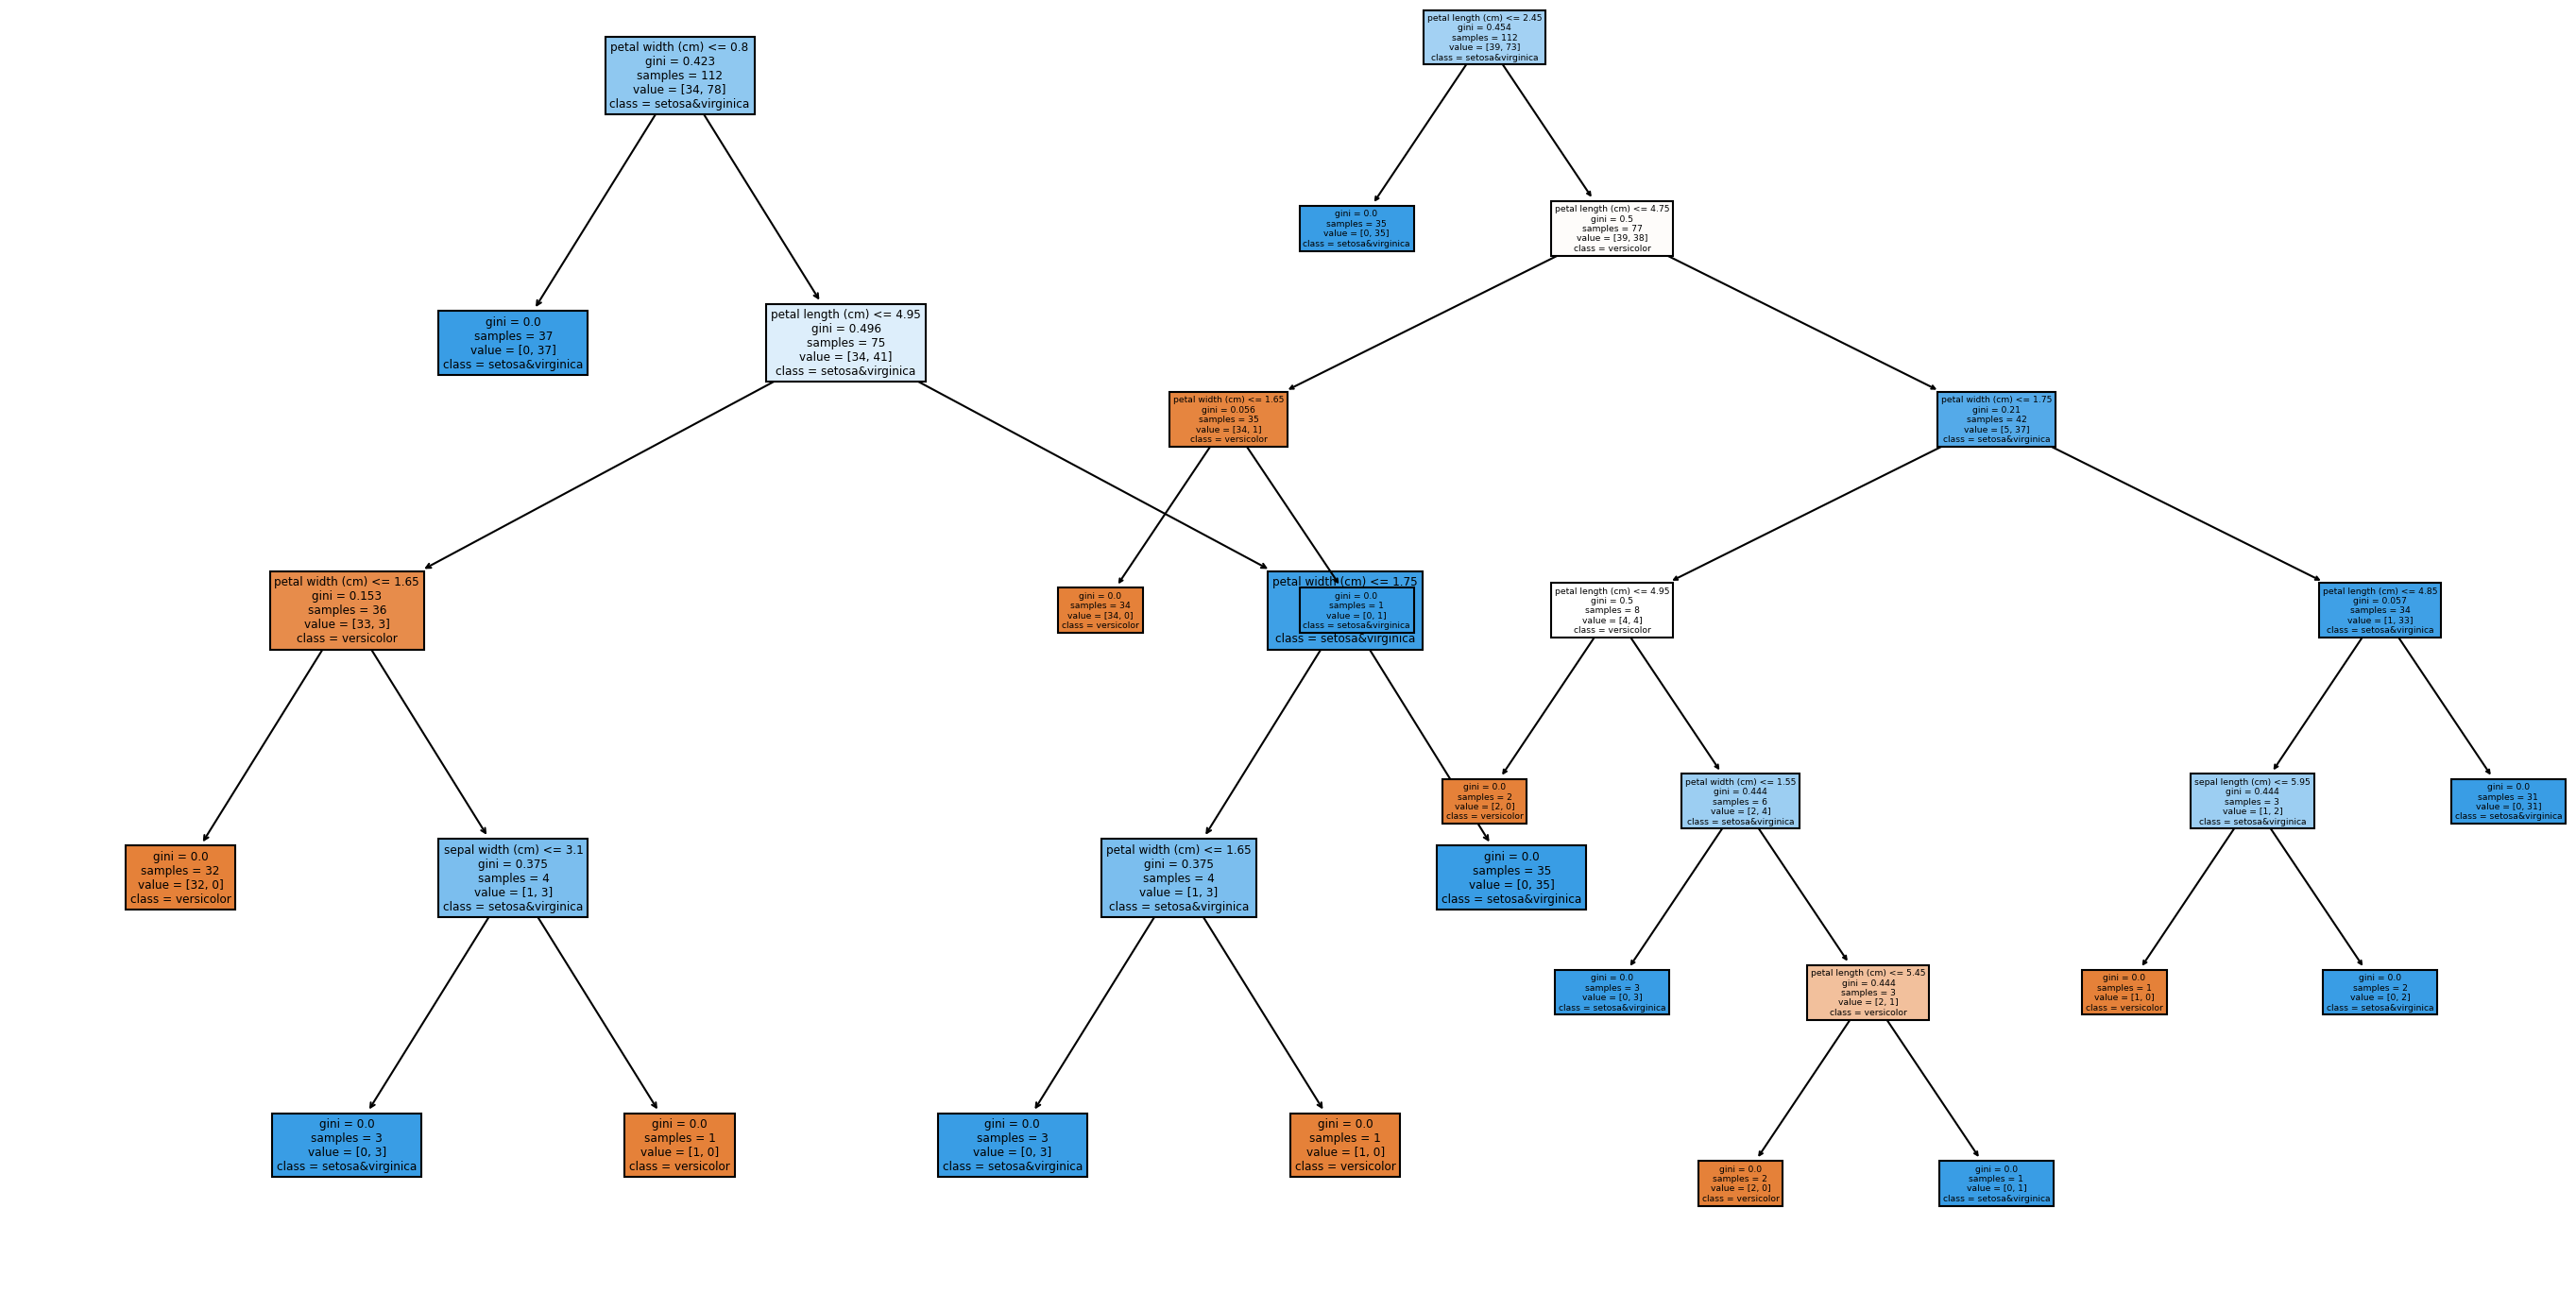

In [8]:
# первый набор точек
clf1 = DecisionTreeClassifier(max_depth=10)
clf1.fit(X_train1, y_train1)

# второй набор точек
clf2 = DecisionTreeClassifier(max_depth=10)
clf2.fit(X_train2, y_train2)


fn = ["sepal length (cm)", "sepal width (cm)", 
      "petal length (cm)", "petal width (cm)"]

cn = ["versicolor", "setosa&virginica"]

fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 6), dpi=150)
tree.plot_tree(clf1,
               feature_names=fn, 
               class_names=cn,
               filled=True, ax=axes[0])

tree.plot_tree(clf2,
               feature_names=fn,
               class_names=cn,
               filled=True, ax=axes[1])
plt.show()

## Переобучение деревьев

Если алгоритм при небольшом изменении признаков сильно меняет свое решение, это, как правило, указывает на переобучение. Алгоритм сильно реагируют на любой шум в данных - доверять его решениям не стоит.

Будем использовать исскуственные данные и нереальный рисунок карандашом для визуализации разделяющих поверхностей.

In [9]:
#handson-ml
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

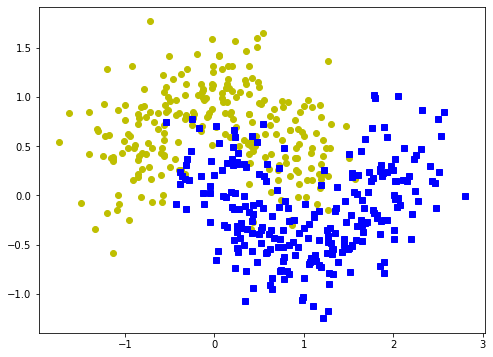

In [10]:
X, y = sklearn.datasets.make_moons(n_samples=500, noise=0.30, random_state=42)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

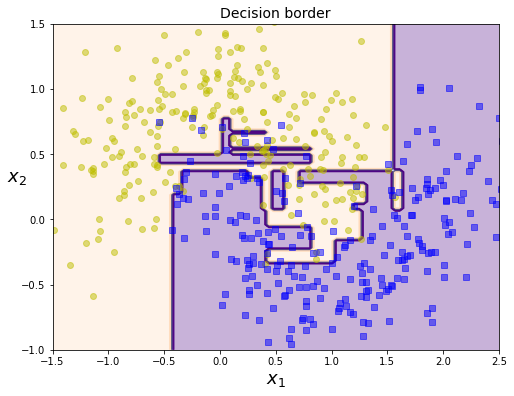

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

plt.figure(figsize=(8, 6))
clf = DecisionTreeClassifier(max_depth=20, random_state=42)
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X, y)
plt.title("Decision border", fontsize=14)
plt.show()

#### Разделяющая поверхность в зависимости от обучающих данных:

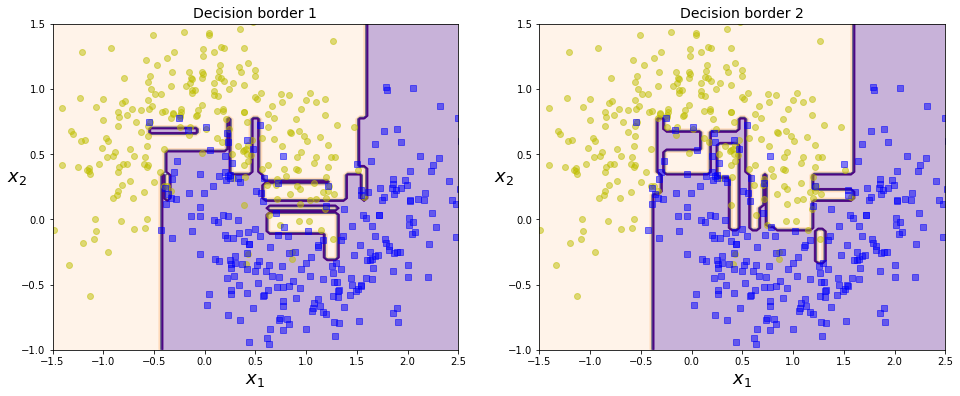

In [12]:
# первый набор точек
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, random_state=1)
clf1 = DecisionTreeClassifier(max_depth=20, random_state=42)
clf1.fit(X_train1, y_train1)

# второй набор точек
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state=2)
clf2 = DecisionTreeClassifier(max_depth=20, random_state=42)
clf2.fit(X_train2, y_train2)

plt.figure(figsize=(16, 6))
plt.subplot(121)
plot_decision_boundary(clf1, X, y)
plt.title("Decision border 1", fontsize=14)
plt.subplot(122)
plot_decision_boundary(clf2, X, y)
plt.title("Decision border 2", fontsize=14)
plt.show()

Границы решений поменялись, причем сильно. Исчезли одни "рваные" границы и появились другие. Опять же, наше дерево неустойчиво, из-за малейшего шума в данных оно может поменять свое предсказания. Оно переобучается на шум в данных. 

Говорят, что у нашего дерева высокий **variance**. 

Можно ли что-то поправить? Ну, у нас в настройках максимальная глубина дерева поставлена равной 20. Это очевидно много. Давайте сделаем дерево глубины 1:

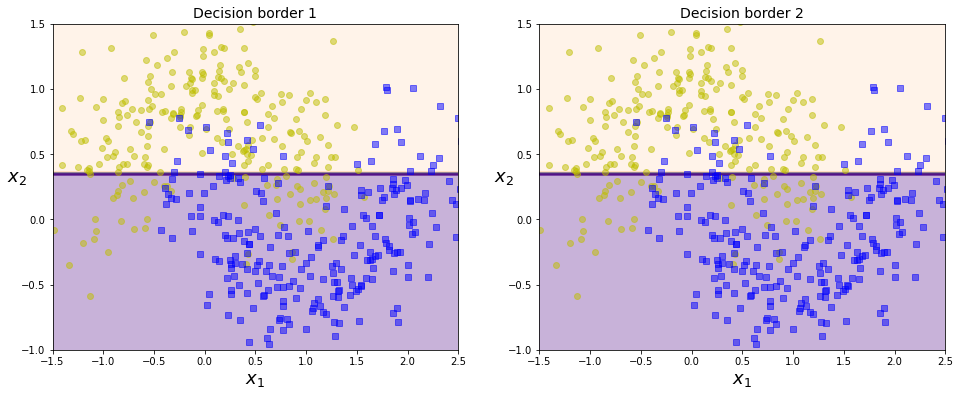

In [13]:
# первый набор точек 
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, random_state=1)
clf1 = DecisionTreeClassifier(max_depth=1, random_state=42) 
clf1.fit(X_train1, y_train1)

# второй набор точек
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state=2)
clf2 = DecisionTreeClassifier(max_depth=1, random_state=42) 
clf2.fit(X_train2, y_train2)

plt.figure(figsize=(16, 6))
plt.subplot(121)
plot_decision_boundary(clf1, X, y)
plt.title("Decision border 1", fontsize=14)
plt.subplot(122)
plot_decision_boundary(clf2, X, y)
plt.title("Decision border 2", fontsize=14)
plt.show()

А теперь глубины 2:

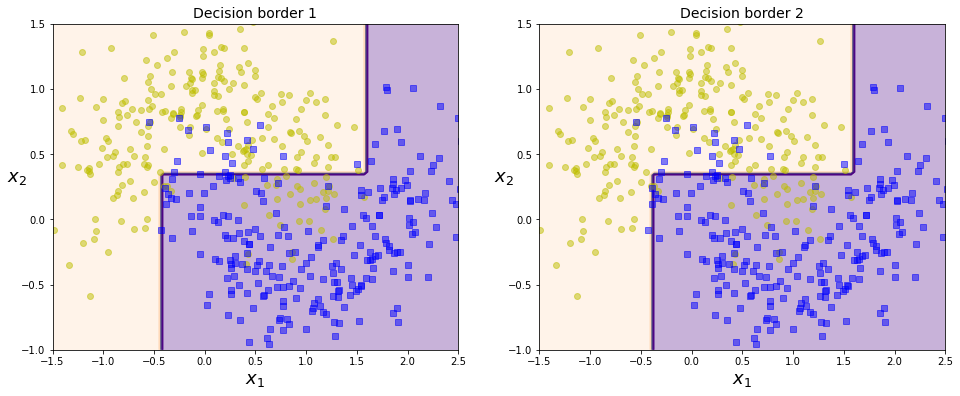

In [14]:
# первый набор точек 
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, random_state=1)
clf1 = DecisionTreeClassifier(max_depth=2, random_state=42) 
clf1.fit(X_train1, y_train1)

# второй набор точек
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state=2)
clf2 = DecisionTreeClassifier(max_depth=2, random_state=42) 
clf2.fit(X_train2, y_train2)

plt.figure(figsize=(16, 6))
plt.subplot(121)
plot_decision_boundary(clf1, X, y)
plt.title("Decision border 1", fontsize=14)
plt.subplot(122)
plot_decision_boundary(clf2, X, y)
plt.title("Decision border 2", fontsize=14)
plt.show()

Сравним разную глубину на одинаковых данных:

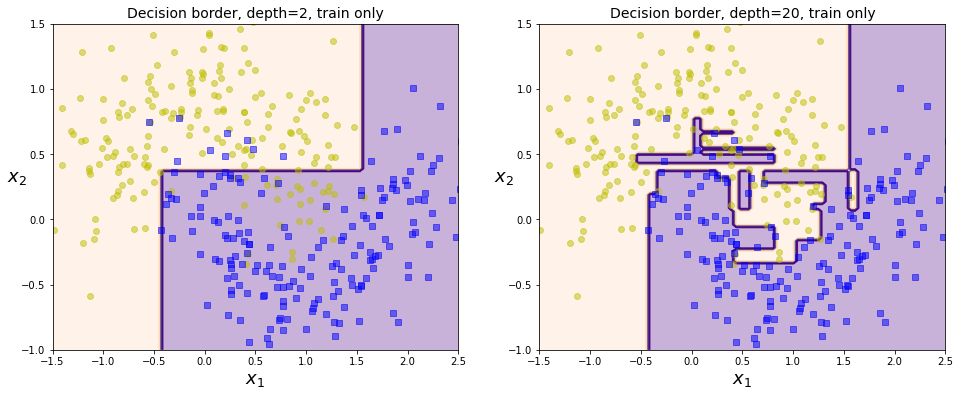

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf1 = DecisionTreeClassifier(max_depth=2, random_state=42)
clf1.fit(X_train, y_train)

clf2 = DecisionTreeClassifier(max_depth=20, random_state=42)
clf2.fit(X_train, y_train)

plt.figure(figsize=(16, 6))
plt.subplot(121)
plot_decision_boundary(clf1, X_train, y_train)
plt.title("Decision border, depth=2, train only", fontsize=14)
plt.subplot(122)
plot_decision_boundary(clf2, X_train, y_train)
plt.title("Decision border, depth=20, train only", fontsize=14)
plt.show()

Мы видим, что в то время как дерево большой глубины выучило нашу тренировочную выборку почти идеально, дерево малой глубины для многих объектов из тренировочной выборки предсказывает не тот класс. Причем, оно не может исправиться просто в силу ограничения на глубину. 

В случае дерева с малой глубиной нам не хватает **сложности модели**, чтобы уловить **внутреннюю структуру данных**. Говорят, что у нашей модели высокий **bias**.

## Bias-variance tradeoff

Ошибка любой модели раскладывается в сумму трех компонент:

$$ Model\_error = Bias^2 + Variance + Irreducible\_error $$

### Bias

Обычно, высокий bias имеют недообученные модели. Например, реальная зависимость, которую мы наблюдаем - нелинейная, а мы пытаемся аппроксимировать ее линией. В этом случае наше решение заведомо смещено (biassed) в сторону линейной модели и мы всегда будем ошибаться в сравнении с реальной моделью данных.

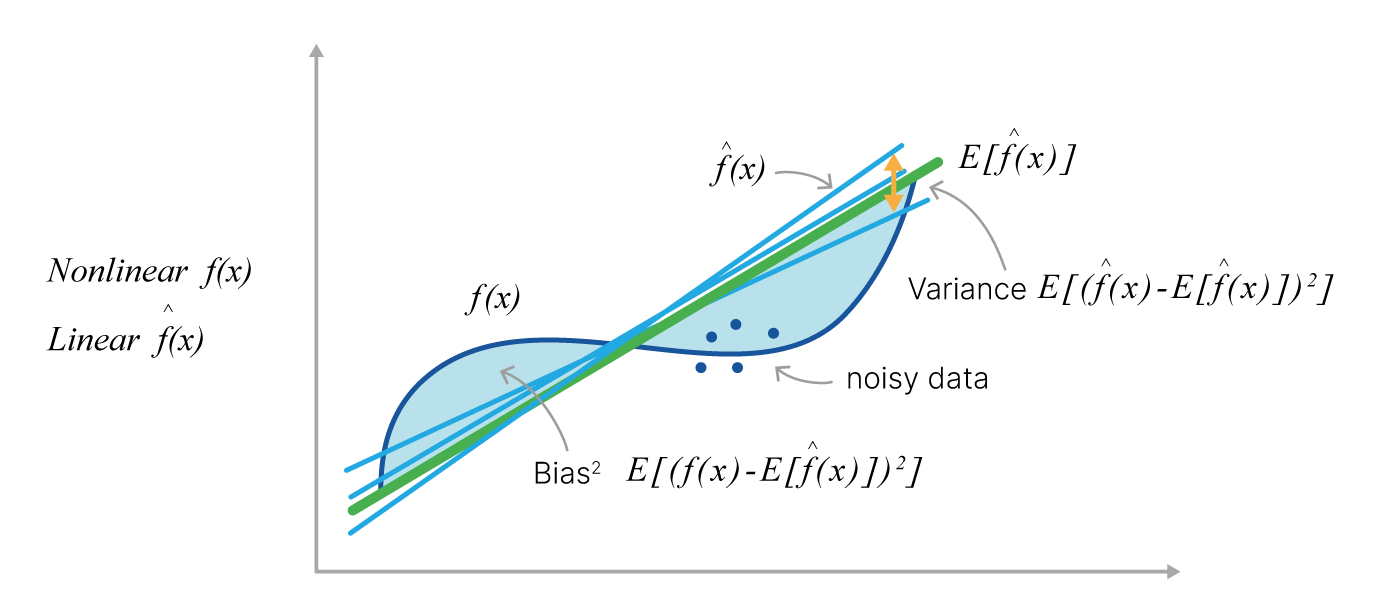

### Variance

Можно получить и обратную ситуацию. Реальная закономерность имеет линейный вид, а мы пытаемся ее аппроксимировать нелинейной моделью. 
В этом случае мы будем выучивать любой шум в данных и пытаться объяснить его нашей моделью. 
Малое изменение в данных будет приводить к большим изменениям в прогнозе модели.

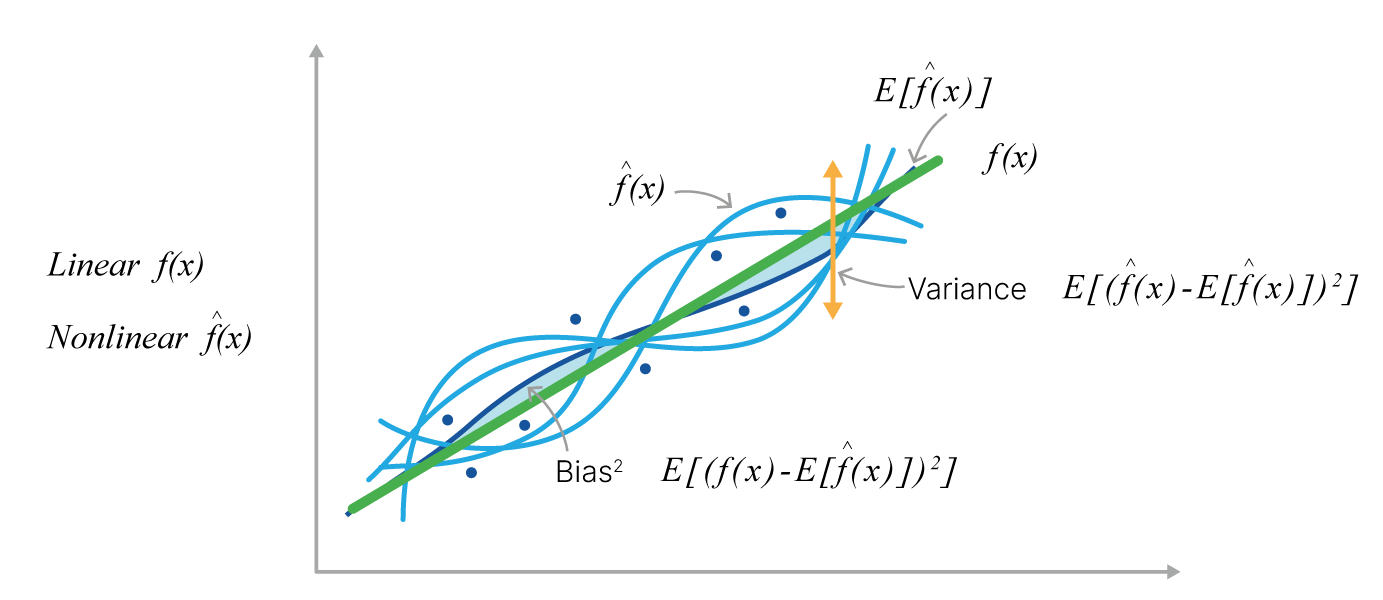

Иногда bias и variance представляет еще таким образом:
1. можно быть очень точным и попадать всегда в центр мишени - это соответствует низкому bias и низкому variance;
2. можно попадать примерно в центр мишени, но при этом с большим разбросом - низкий bias, но высокий variance;
3. можно стрелять кучно, но не туда) - это высокий bias и низкий variance;
4. ну а можно просто стрелять наугад куда душа зовет - это высокий bias и высокий variance.

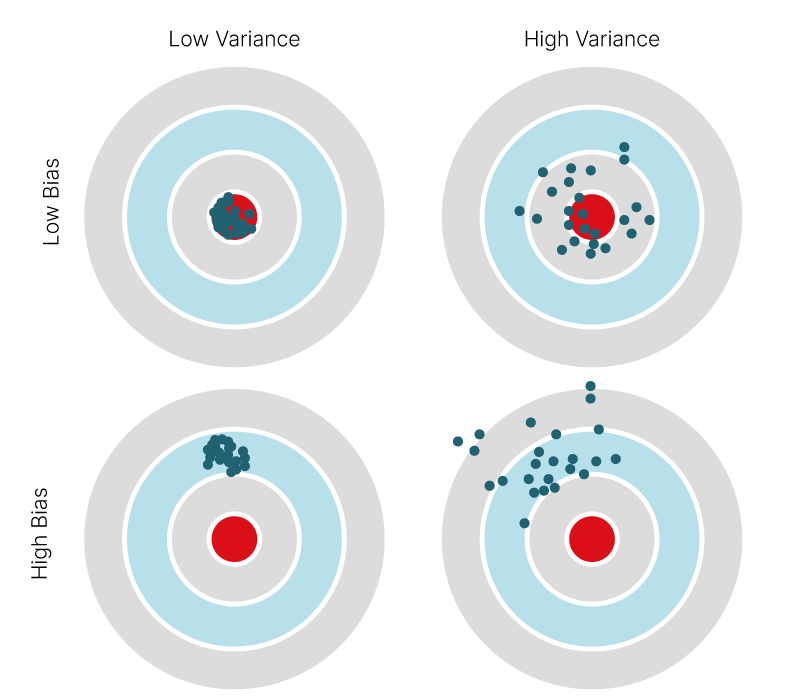

### Irreducible error<a class="anchor" style="autocontent" id="Irreducible-error"/><br>
В идеальном для нас случае - когда мы угадали с моделью наших данных, гипотетически можно получить. $$Bias=0, Variance=0$$
Однако, у нас есть ошибки в измерении самой предсказываемой величины. Из-за этого наша модель всегда будет иметь некий уровень ошибки, ниже которого опуститься нельзя.

### Bias vs variance<a class="anchor" style="autocontent" id="Bias-vs-variance"/><br>

В реальности же, когда реальную модель данных угадать в точности почти невозможно, есть bias-variance tradeoff - нельзя бесконечно уменьшать и Bias, и Variance. Есть какая-то точка оптимума. С какого-то момента при уменьшении Bias начнет увеличиваться Variance, и наоборот. 
При этом, можно построить  связь этих величин с увеличинием сложности модели (capacity)

<img src ="http://edunet.kea.su/repo/src/L03_Classic_ML/img_license/bias_variance_tradeoff.png" width="450">

### Применительно к деревьям<a class="anchor" style="autocontent" id="Применительно-к-деревьям"/><br>
Дерева малой глубины имеет малую сложнось - и высокий bias. 
Дерево большой глубины имеет высокую сложность - и высокий variance. 

Можно подобрать для дерева идеальную capacity, когда Bias и Variance будут суммарно давать наименьший вклад в ошибку. Этим мы занимаемся при подборе параметров. 
Но оказывается, есть и другие способы борьбы с variance и/или bias, которые мы разберем позже.

Заметим, что если бы могли говорить не просто решение дерева, а привязывать к этому какую-то статистику, например, сколько деревьев, построенных по подобной процедуре, приняли такое же решение - было бы легче.

Если наложить решающие границы 100 решающих деревьев, построенных на разных выборках из X, y, то мы увидим, что "хорошие области", соответствующие реальному разделению данных будут общими между деревьями, а плохие - индивидуальны. 
К сожалению, в реальности, мы не можем брать бесконечное число наборов данных из генеральной совокупности (представленной в данном случае X, y)

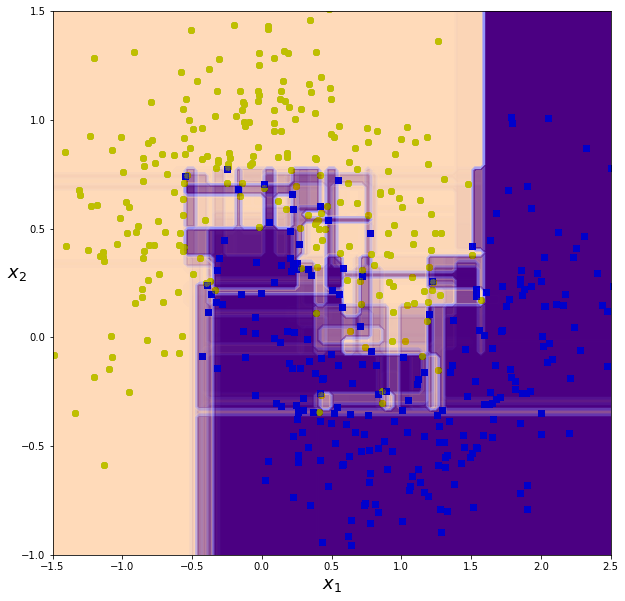

In [16]:
plt.figure(figsize=(10, 10))

for i in range(1, 101):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
    clf = DecisionTreeClassifier(max_depth=20, random_state=0)
    clf.fit(X_train, y_train)
    plot_decision_boundary(clf, X, y, alpha=0.02, contour=False)

plt.show()

## Бутстрэп

Часто мы хотим получить какое-то представление о точности какой-либо нашей оценки - медианы выборки, качества модели, корреляции между двумя переменными и тд. И мы не знаем, как распределена характеристика: которую мы оцениваем. 

Есть много подходов к тому, как получить такую оценку и один из них - бутстрэп &mdash; универсальный метод оценки статистической точности.

<img src ="https://kodomo.fbb.msu.ru/FBB/year_20/bootstrap_img.png" width="600">

Что мы делаем: 

1. Случайным образом извлекаем наборы данных с возвращением из обучающих данных так, чтобы каждая выборка (обычно их называют **псевдовыборками**) имела тот же размер, что и исходное обучающее множество. Это делается $N$ раз, создавая $N$ множеств бутстрэпа. 

2. Для каждой полученной псевдовыборки считаем характеристику, для которой хотим получить оценку. Это может быть любая величина, вычисленная по обучающим данным, например, предсказание в некоторой входной точке.

3. В результате такой процедуры получаем $N$ значений характеристики. По этой выборке можем оценить любой аспект распределения этой характеристики.С

4. Можем построить 95% доверительный интервал для нашей характеристики - для этого отрезаем 2.5% самых больших значений и самых малых. 

Напишем функцию, которая будет таким образом рассчитывать нам распределение какой-то метрики:

In [17]:
def bootstrap_metric(x,
                     y,
                     metric_fn,
                     samples_cnt=1000,
                     alpha=0.05,
                     random_state=42):
    size = len(x)
    
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], 
                                 replace=True)
        
        x_boot = x[poses]
        y_boot = y[poses]
        
        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val
    
    return b_metric

### Классифицируем людей с больным сердцем

In [18]:
!pip install gdown
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv 

You should consider upgrading via the '/home/daniil/.pyenv/versions/3.8.12/bin/python3.8 -m pip install --upgrade pip' command.
/home/daniil/.pyenv/versions/3.8.12/lib/python3.8/site-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y-
To: /home/daniil/Documents/Teaching/BI_2023_ml/BI-ml-2023/lecture_5_ensembles/lecture/heart.csv
100%|██████████████████████████████████████| 11.3k/11.3k [00:00<00:00, 4.20MB/s]


In [19]:
heart_dataset = pd.read_csv("heart.csv")
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"] > 0
X_train, X_test, y_train, y_test = train_test_split(X, y.values, random_state=42)

In [20]:
logr_model = GridSearchCV(LogisticRegression(solver="liblinear", max_iter=100000),
                          {"penalty": ("l1", "l2"),
                           "C": [0.01, 0.1, 1, 10, 100]}
                          ).fit(X_train, y_train)

knn_model = GridSearchCV(KNeighborsClassifier(),
                         {"n_neighbors": [3, 5, 7, 9, 11, 15],
                          "weights": ["uniform", "distance"],
                          "p": [1, 2]}).fit(X_train, y_train)

# мало объектов в листе - плохие оценки вероятностей класса - модель переобучается
dt_model = GridSearchCV(DecisionTreeClassifier(), 
                          {"max_depth": [1, 3, 5, 7, 10],
                           "min_samples_leaf": [1, 3, 5, 10]}
                        ).fit(X_train, y_train)

/home/daniil/anaconda3/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/daniil/anaconda3/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/daniil/anaconda3/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/daniil/anaconda3/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/daniil/anaconda3/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/daniil/anaconda3/lib/pyt

In [21]:
y_pred1 = logr_model.predict_proba(X_test)[:, 1]
y_pred2 = knn_model.predict_proba(X_test)[:, 1]
y_pred3 = dt_model.predict_proba(X_test)[:, 1]

qual1 = roc_auc_score(y_true=y_test, y_score=y_pred1)
qual2 = roc_auc_score(y_true=y_test, y_score=y_pred2)
qual3 = roc_auc_score(y_true=y_test, y_score=y_pred3)

/home/daniil/anaconda3/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [22]:
print(f"Logistic regression roc-auc: {qual1:.03f}")
print(f"KNN roc-auc: {qual2:.03f}")
print(f"DecisionTreeClassifier roc-auc: {qual3:.03f}")

Logistic regression roc-auc: 0.911
KNN roc-auc: 0.836
DecisionTreeClassifier roc-auc: 0.847


In [23]:
boot_score_logreg = bootstrap_metric(y_test, 
                                     y_pred1, 
                                     metric_fn=roc_auc_score)
boot_score_knn = bootstrap_metric(y_test,
                                  y_pred2,
                                  metric_fn=roc_auc_score)
boot_score_dt = bootstrap_metric(y_test,
                                 y_pred3,
                                 metric_fn=roc_auc_score)

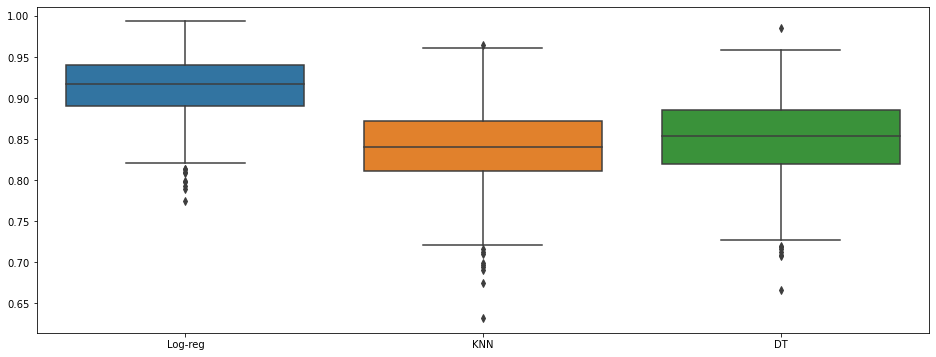

In [24]:
plt.figure(figsize=(16, 6))
sns.boxplot(y=np.concatenate([boot_score_logreg,
                              boot_score_knn, 
                              boot_score_dt]),
            x=["Log-reg"] * 1000 + ["KNN"] * 1000 + ["DT"] * 1000)
plt.show()

### Чем ещё знаменит бутстрэп?

В классической биоинформатике bootstrap чаще всего используется в филогенетике для того чтобы оценить поддержку каждой из ветвей реконструированного по выравниванию дерева. В этом случае сэмплируются с повторениями колонки исходного выравнивания, по полученному множеству деревьев строится консенсусное дерево, после чего для каждой из его ветвей оценивается процент деревьев в выборке, в которых эта ветвь встретилась.

https://doi.org/10.1093/bib/bbq079
<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/dtrees/phylo_bootstrap.png" alt="Drawing" width= "800px;"/>

## Ансамбли

Есть 10 объектов, в реальности все принадлежат классу 1


<font color=#4B0082 size=30>1111111111</font>

Пусть у нас есть три **независимых** классификатора A, B и C. Каждый предсказывает 1 в 70% случаев. 


Мы хотим получить общий классификатор на основании этих трех. 



Мы хотим получить предсказание базовых классификаторов, применить к ним какую-то функцию, которая выдаст итоговой ответ. Вид этой функции задается заранее.

### Обычное голосование

Будем просто усреднять предсказание наших классификаторов


$$ h(x) = \dfrac 1 T \sum_{i=1}^{T}a_i(x) $$

Допустим, у нас 3 классификатора, которые предсказывают независимо друг от друга.

Посчитаем вероятность того, что:

 1. все три классификатора верны: 0.7 * 0.7 * 0.7 = 0.3429
 2. два классификатора верны: 0.7 * 0.7 * 0.3 + 0.7 * 0.3 * 0.7 + 0.3 * 0.7 * 0.7 = 0.4409
 
Таким образом, если брать большинство голосов, то мы будем в 78% случаев предсказывать верно. Мы взяли 3 классификатора, которые сами по себе были не очень хорошими, и получили классификатор лучшего качества. 
Очевидно, что если взять 4, 5, 10 классификаторов, то ситуация будет становится лучше. 

Пусть теперь у нас три классификатора, выдающие следующие предсказания

<font color=#4B0082 size=30>11111111</font><font color=#ffdab9 size=30>00</font> - 80% accuracy

<font color=#4B0082 size=30>11111111</font><font color=#ffdab9 size=30>00</font> - 80% accuracy

<font color=#4B0082 size=30>1</font></font><font color=#ffdab9 size=30>0</font><font color=#4B0082 size=30>111111</font><font color=#ffdab9 size=30>00</font> - 70% accuracy

Если объединим предсказания, то получим:

<font color=#4B0082 size=30>11111111</font><font color=#ffdab9 size=30>00</font> - 80% accuracy

Потому что очень **высокая зависимость предсказаний**. Выше видно, что два классификатора предсказывают абсолютно одинаково. Вероятность, что они делают это случайно, очень мала. 

А вот если возьмем такие классификаторы, то все получится:
    
<font color=#4B0082 size=30>11111111</font><font color=#ffdab9 size=30>00</font> - 80% accuracy

<font color=#ffdab9 size=30>0</font><font color=#4B0082 size=30>111</font><font color=#ffdab9 size=30>0</font><font color=#4B0082 size=30>111</font><font color=#ffdab9 size=30>0</font><font color=#4B0082 size=30>1</font> - 70% accuracy

<font color=#4B0082 size=30>1</font><font color=#ffdab9 size=30>000</font><font color=#4B0082 size=30>1</font><font color=#ffdab9 size=30>0</font><font color=#4B0082 size=30>1111</font> - 60% accuracy


Усреднение:

<font color=#4B0082 size=30>11111111</font><font color=#ffdab9 size=30>0</font><font color=#4B0082 size=30>1</font> - 90% accuracy

## Bagging  = Bootstrap aggregation

Нам надо откуда-то брать классификаторы, которые сами по себе предсказывают лучше, чем случайное число, при этом они должны быть не коррелированы. На самом деле это нетривиальная задача: откуда нам брать классификаторы, учитывая, что у нас 1 датасет?

<img src ="https://edunet.kea.su/repo/src/L03_Classic_ML/img_license/bootstrap.png" width="600">

Первый вариант — нам поможет уже расмотренный bootstrap:

1. Делаем из нашего исходного датасета N псевдовыборок такого же размера с повторениями. 

2. На каждой полученной псевдовыборке строим отдельную модель. Чтобы полученным модели были слабо зависимы, будем использовать алгоритм, который чувствителен к небольшим изменениям в выборке. 

3. Получаем N слабо зависимых моделей. 

4. Когда нам нужно сделать предсказание для нового объекта, делаем предсказание каждой из N моделей, а затем усредняем предсказание.

В sklearn для bagging можно использовать класс `BaggingClassifier`.

## Метод случайных подпространств (RSM, random subspace method)

Второй вариант получения пссевдовыборок — мы можем сэмплировать не объекты, а признаки.  При этом бесполезно иметь в выборке два одинаковых признака, потом мы делаем выборки меньшего размера, чем исходное число признаков и без повторений. 

<img src ="https://edunet.kea.su/repo/src/L03_Classic_ML/img_license/random_subspace_method.png" width="1100">

Обычно для каждой модели выбирают:

 для задач классификации:$$\sqrt{feature\_cnt}$$ для задач регрессии : $$ \frac {feature\_cnt} {3}$$  Хотя строгих правил нет, этот параметр можно подбирать на кросс-валидации.

## Комбинация RSM и Bagging

Можно объединить оба способа: применяем bootstrap к объектам (получается выборка одного размера, но с повторяющимися объектами, а каких-то объектов не будет), и, кроме этого, выкидываем часть признаков. Зачем это нужно? В этом случае мы получим еще более сильно отличающиеся друг от друга случайные выборки. 

sklearn.ensemble.BaggingClassifier и sklearn.ensemble.BaggingRegressor  вопреки названию может подддерживать оба способа.



<img src ="https://edunet.kea.su/repo/src/L03_Classic_ML/img_license/rsm_and_bagging.png" width="300">

## Случайный лес

Будем брать деревья большой глубины.  Незначительные изменения в данных приводят к значительным  изменением в топологии таких деревьев. Таким образом мы приходим к **случайному лесу** = Bagging + RSM над деревом решений.

При этом RSM в классическом случайном лесе делается не на уровне дерева , а на уровне узла. В каждом узле дерева, когда мы выбираем лучшее разбиение его на два дочерних, мы просматриваем не все признаки, а только определенное их количество.

<img src ="https://edunet.kea.su/repo/src/L03_Classic_ML/img_license/random_forest.png" width="700">


Обычно случайный лес работает лучше, чем отдельно случайно взятое дерево. Но главное - случайный лес намного более устойчив к шуму. 
Оказывается, что это свойство до сих пор позволяет случайному лесу успешно использоваться в областях с шумными данными. Например, в биологии. 

### Зависимость качества случайного леса от числа деревьев

In [25]:
calif_housing = sklearn.datasets.fetch_california_housing()
X = calif_housing.data
y = calif_housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [26]:
from sklearn.metrics import mean_squared_error
def train_and_test_regressor(models, X_train, y_train, X_test, y_test):
    for name, model in models.items():
        print(f"Fitting {name}")
        model.fit(X_train, y_train)
    predictions = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        predictions[name] = y_pred
        
    boot_scores = {}

    for name, y_pred in predictions.items():
        print(f"Calculating bootstrap score for {name}")
        boot_score = bootstrap_metric(y_test, 
                                      y_pred, 
                                      metric_fn=lambda x, y: mean_squared_error(y_true=x, 
                                                                                y_pred=y))
        boot_scores[name] = boot_score
        
    
    results = pd.DataFrame(boot_scores)
    
    results = results.melt(value_vars=results.columns,
                           value_name="mse", 
                           var_name="model")
    return results

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
models_rf = {}

models_rf["DT"] =  GridSearchCV(DecisionTreeRegressor(), 
                          {"max_depth":[1, 3, 5, 7, 10],
                           "min_samples_leaf": [1, 3, 5, 10]} 
                     )

# (https://stackoverflow.com/questions/42757892/how-to-use-warm-start)
for n_estimators in [3, 5, 10, 50, 100, 150, 250]:
    models_rf[f"RF{n_estimators}"] = RandomForestRegressor(n_estimators=n_estimators,
                                                           random_state=42, 
                                                           n_jobs=-1)

results_rf = train_and_test_regressor(models_rf, X_train, y_train, X_test, y_test)

Fitting DT
Fitting RF3
Fitting RF5
Fitting RF10
Fitting RF50
Fitting RF100
Fitting RF150
Fitting RF250
Calculating bootstrap score for DT
Calculating bootstrap score for RF3
Calculating bootstrap score for RF5
Calculating bootstrap score for RF10
Calculating bootstrap score for RF50
Calculating bootstrap score for RF100
Calculating bootstrap score for RF150
Calculating bootstrap score for RF250


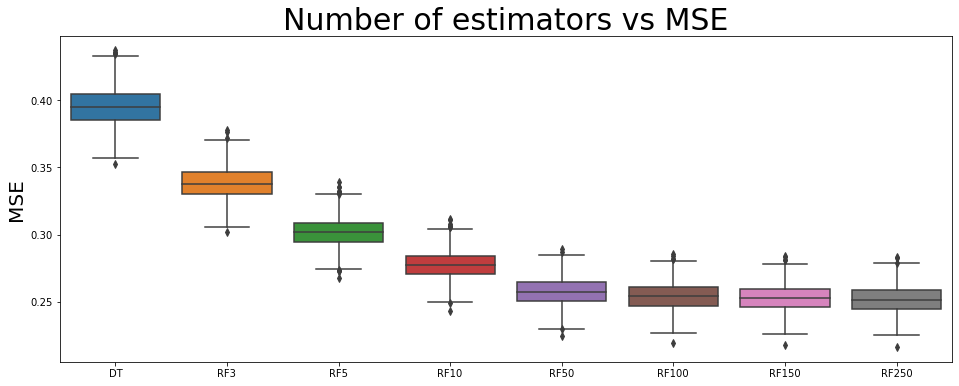

In [28]:
plt.figure(figsize=(16,6))
sns.boxplot(data=results_rf, y="mse", x="model")
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("Number of estimators vs MSE", size=30)
plt.show()

Видим, что действительно, с какого-то момента качество модели почти не изменяется, увеличение числа базовых классифакторов как минимум не ухудшает ее качество

### Зависимость качества случайного леса от глубины дерева

Мы уже обсуждали, что чем больше глубина дерева, тем большая нескорелированность базовых моделей будет получаться. По идее, в случайном лесе важно использовать именно глубокие деревья, причем, в большинстве случаев их глубину не надо ограничивать (или ограничивать большими значениями порядка 10-12). Проверим это. 

Кроме этого, будем добавлять кроме случайного леса с заданной глубиной еще одиночное дерево такой же глубины.

In [29]:
models_depth = {}

for depth in [1, 3, 5, 7, 9, 11, 13, None]:

    models_depth[f"DT_depth{depth}"] = DecisionTreeRegressor(max_depth=depth,
                                                             random_state=42)
    
    models_depth[f"RF_depth{depth}"] = RandomForestRegressor(n_estimators=100,
                                                             max_depth=depth,
                                                             random_state = 42, 
                                                             n_jobs=-1)

results_depth = train_and_test_regressor(models_depth, X_train, y_train, X_test, y_test)

Fitting DT_depth1
Fitting RF_depth1
Fitting DT_depth3
Fitting RF_depth3
Fitting DT_depth5
Fitting RF_depth5
Fitting DT_depth7
Fitting RF_depth7
Fitting DT_depth9
Fitting RF_depth9
Fitting DT_depth11
Fitting RF_depth11
Fitting DT_depth13
Fitting RF_depth13
Fitting DT_depthNone
Fitting RF_depthNone
Calculating bootstrap score for DT_depth1
Calculating bootstrap score for RF_depth1
Calculating bootstrap score for DT_depth3
Calculating bootstrap score for RF_depth3
Calculating bootstrap score for DT_depth5
Calculating bootstrap score for RF_depth5
Calculating bootstrap score for DT_depth7
Calculating bootstrap score for RF_depth7
Calculating bootstrap score for DT_depth9
Calculating bootstrap score for RF_depth9
Calculating bootstrap score for DT_depth11
Calculating bootstrap score for RF_depth11
Calculating bootstrap score for DT_depth13
Calculating bootstrap score for RF_depth13
Calculating bootstrap score for DT_depthNone
Calculating bootstrap score for RF_depthNone


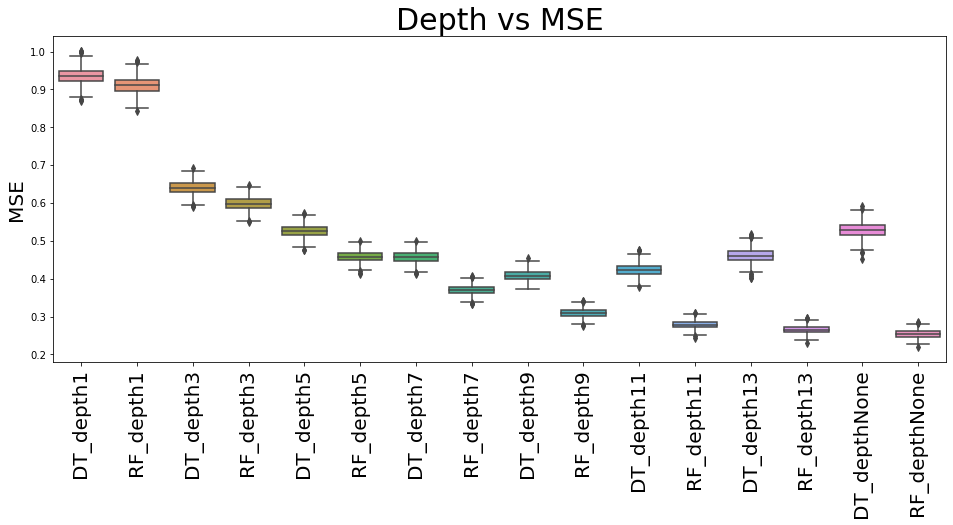

In [30]:
plt.figure(figsize=(16,6))
ax = sns.boxplot(data=results_depth, y="mse", x="model")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("Depth vs MSE", size=30)
plt.xticks(size=20)
plt.show()

Действительно, в данном случае модель без ограничения на глубину дерева показывает наилучшие результаты. 
Модель же с малой глубиной дерева работает сильно хуже. 

Качество случайного леса с малой глубиной дерева не отличается от качества одиночного дерева той же глубины. Опять же, деревья малой глубины слабо отличаются друг от друга, потому усреднение их предсказаний не дает почти никакого выигрыша.

Стоит все же отметить, что в случае малых выборок, незначительные ограничения на глубину дерева могут дать выигрыш.

## Случайный лес и bias-variance tradeoff

Случайный лес - инструмент для уменьшения variance нашей модели. Можно показать, что при стремлении числа моделей в ансамбле к бесконечности, а их коррелированности - к 0, variance ансамбля стремится к нулю. Однако при этом bias ансамбля будет равен bias базовой модели 

Продемонстрируем это:

In [31]:
X, y = sklearn.datasets.make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

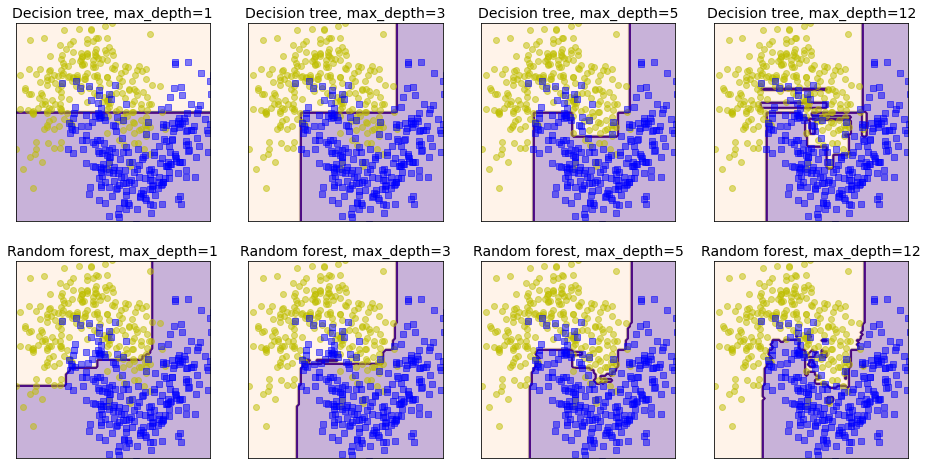

In [32]:
plt.figure(figsize=(16, 8))

plt.subplot(241)
dt1 = DecisionTreeClassifier(max_depth=1)
dt1.fit(X_train, y_train)
plot_decision_boundary(dt1, X, y)
plt.xticks([], [])
plt.yticks([], [])
plt.title("Decision tree, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(242)
dt3 = DecisionTreeClassifier(max_depth=3)
dt3.fit(X_train, y_train)
plot_decision_boundary(dt3, X, y)
plt.title("Decision tree, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(243)
dt5 = DecisionTreeClassifier(max_depth=5)
dt5.fit(X_train, y_train)
plot_decision_boundary(dt5, X, y)
plt.title("Decision tree, max_depth=5", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(244)
dt12 = DecisionTreeClassifier(max_depth=12)
dt12.fit(X_train, y_train)
plot_decision_boundary(dt12, X, y)
plt.title("Decision tree, max_depth=12", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(245)
rf1 = RandomForestClassifier(max_depth=1, n_estimators=500, n_jobs=-1) 
rf1.fit(X_train, y_train)
plot_decision_boundary(rf1, X, y)
plt.title("Random forest, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(246)
rf3 = RandomForestClassifier(max_depth=3, n_estimators=500, n_jobs=-1) 
rf3.fit(X_train, y_train)
plot_decision_boundary(rf3, X, y)
plt.title("Random forest, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(247)
rf5 = RandomForestClassifier(max_depth=5, n_estimators=500, n_jobs=-1) 
rf5.fit(X_train, y_train)
plot_decision_boundary(rf5, X, y)
plt.title("Random forest, max_depth=5", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(248)
rf12 = RandomForestClassifier(max_depth=12, n_estimators=500, n_jobs=-1) 
rf12.fit(X_train, y_train)
plot_decision_boundary(rf12, X, y)
plt.title("Random forest, max_depth=12", fontsize=14)
plt.subplots_adjust()
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], []);

## Boosting

Вы наверняка слышали о нем, потому что градиентный boosting — предмет большого количества мемов про машинное обучение, потому что он помогает получить решение, которое сложно побить другими видами моделей.

В то время как случайный лес представлял собой попытку стрелять по мишени много раз в надежде, что в среднем мы попадем в нее попадем, идея бустинга больше похожа на игру в гольф. Пусть каждая модель будет представлять собой один слабенький удар клюшкой. А последующие удары — будут корректировать результаты этого удара, постепенно приближаясь к лунке. 

<img src ="https://edunet.kea.su/repo/src/L03_Classic_ML/img_license/bag_vs_boost.jpg" width="900">

Бустинг позволяет нам на основе большого числа слабых моделей получить одну сильную. Опять же, в качестве модели используется дерево решений, но не большой глубины, а наоборот, маленькой. Чтобы оно само по себе в принципе не могло выучить выборку хорошо. 

<img src ="https://edunet.kea.su/repo/src/L03_Classic_ML/img_license/learners.png" width="500">

Цель i-й модели в ансамбле — скорректировать ошибки предыдущих i-1 моделей. В результате, когда мы суммируем вклады всех моделей ансамбля, получается хорошее предсказание.

## Gradient boosting (градиентный бустинг)

Как и многие модели машинного обучения, бустинг (с помощью добавленных слабых моделей) минимизируют функции ошибки.

<img src ="https://edunet.kea.su/repo/src/L03_Classic_ML/img_license/gradient_descent.png" width="450">


Как он их минимизирует? Точно также, как линейная модель. Он использует градиентный спуск. 
Можно сделать следующее: у нас есть исходное приближение. Мы как-то ошибаемся. Считаем градиент ошибки, дальше пытаемся его предсказать. Делаем новое приближение. Опять как-то ошибаемся — и повторяем все еще и еще. 

Для объекта из тестовой выборки:

 1. Первая модель обеспечивает нам исходное приближение.
 2. Вторая модель пытается предсказать градиент ошибки. Зная градиент ошибки для тестового объекта, мы можем эту ошибку уменьшить, получив новое приближение.
 3. Третья модель пытается предсказать градиент ошибки нового приближения. Опять, зная его можем получить еще одно, более точное приближение.
 4. Повторяем, пока не пройдем все N моделей.

Оказывается, такой подход позволяет достигать state-of-the art результатов при работе с табличными данными.

Важные параметры бустинга, о которых стоит почитать:

* lr - скорость обучения
* n_estimators - число деревьев в ансамбле
* max_depth - глубина деревьев
* min_samples_leaf - минимальное число объектов в листе
* и еще куча других, но об этом ниже

## Градиентный бустинг и bias-variance tradeoff

В то время как случайный лес только уменьшал variance модели, бустинг стремится уменьшить и bias, и variance.

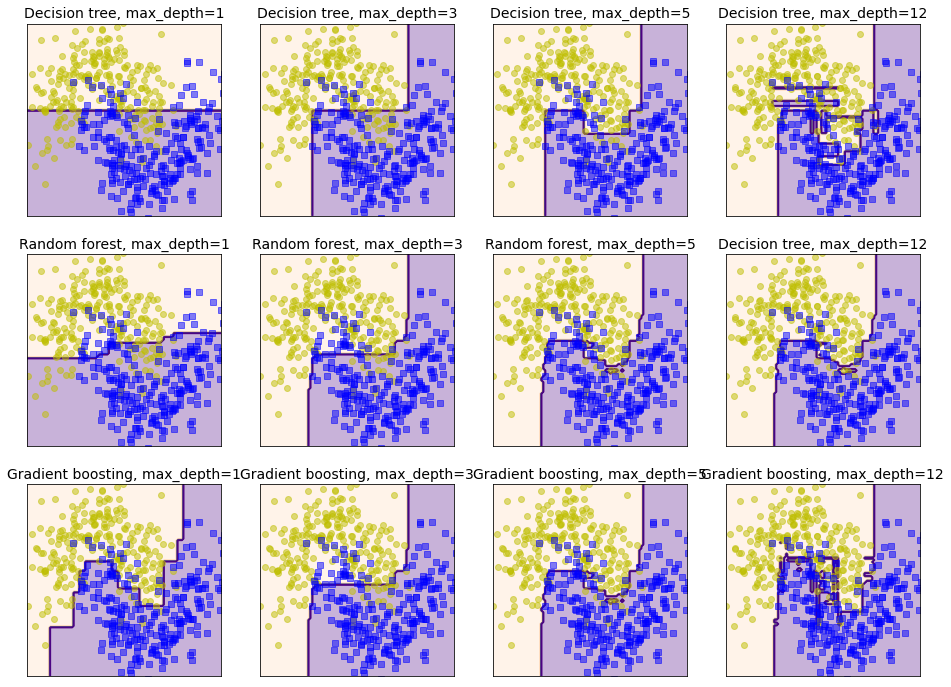

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

X, y = sklearn.datasets.make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


plt.figure(figsize=(16,12))
plt.subplot(341)
dt1 = DecisionTreeClassifier(max_depth=1) 
dt1.fit(X_train, y_train)
plot_decision_boundary(dt1, X, y)
plt.xticks([], [])
plt.yticks([], [])

plt.title("Decision tree, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(342)
dt3 = DecisionTreeClassifier(max_depth=3) 
dt3.fit(X_train, y_train)
plot_decision_boundary(dt3, X, y)
plt.title("Decision tree, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(343)
dt5 = DecisionTreeClassifier(max_depth=5) 
dt5.fit(X_train, y_train)
plot_decision_boundary(dt5, X, y)
plt.title("Decision tree, max_depth=5", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(344)
dt12 = DecisionTreeClassifier(max_depth=12) 
dt12.fit(X_train, y_train)
plot_decision_boundary(dt12, X, y)
plt.title("Decision tree, max_depth=12", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(345)
rf1 = RandomForestClassifier(max_depth=1, n_estimators=500, n_jobs=-1) 
rf1.fit(X_train, y_train)
plot_decision_boundary(rf1, X, y)
plt.title("Random forest, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(346)
rf3 = RandomForestClassifier(max_depth=3, n_estimators=500, n_jobs=-1) 
rf3.fit(X_train, y_train)
plot_decision_boundary(rf3, X, y)
plt.title("Random forest, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(347)
rf5 = RandomForestClassifier(max_depth=5, n_estimators=500, n_jobs=-1) 
rf5.fit(X_train, y_train)
plot_decision_boundary(rf5, X, y)
plt.title("Random forest, max_depth=5", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(348)
rf12 = RandomForestClassifier(max_depth=5, n_estimators=500, n_jobs=-1) 
rf12.fit(X_train, y_train)
plot_decision_boundary(rf12, X, y)
plt.title("Decision tree, max_depth=12", fontsize=14)
plt.subplots_adjust()
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(349)
boost1 = GradientBoostingClassifier(max_depth=1, n_estimators=250)
boost1.fit(X_train, y_train)
plot_decision_boundary(boost1, X, y)
plt.title("Gradient boosting, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(3, 4, 10)
boost3 =  GradientBoostingClassifier(max_depth=3, n_estimators=250) 
boost3.fit(X_train, y_train)
plot_decision_boundary(rf3, X, y)
plt.title("Gradient boosting, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(3, 4, 11)
boost5 =  GradientBoostingClassifier(max_depth=5, n_estimators=250) 
boost5.fit(X_train, y_train)
plot_decision_boundary(rf5, X, y)
plt.title("Gradient boosting, max_depth=5", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(3, 4, 12)
boost12 =  GradientBoostingClassifier(max_depth=5, n_estimators=250) 
boost12.fit(X_train, y_train)
plot_decision_boundary(boost12, X, y)
plt.title("Gradient boosting, max_depth=12", fontsize=14)
plt.subplots_adjust()
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])
plt.show()

## Модификации градиентного бустинга

Есть много модификаций градиентного бустинга. В отличии от реализации в sklearn, большая часть из них умеет параллелиться на CPU или даже на GPU. 

Потому при работе с реальными данными использовать градиентный бустинг из sklearn не стоит. XGBoost и/или LigthGBM дадут результат как правило лучше и быстрее.

### XGBoost

Мы не хотим, чтобы модели по пути были сложными. Пусть минимально отличающиеся от случайного, но при этом не очень сложными.

Поэтому XGBoost вводит специальный штраф за сложные деревья (большей глубины, чем 2 — 3). За счет того, что в градиентном бустинге можно минимизировать любую дифференцируемую функцию ошибок, мы просто добавляем штраф напрямую в функцию ошибок исходного градиентного бустинга.

In [34]:
import xgboost

calif_housing = sklearn.datasets.fetch_california_housing()
X = calif_housing.data
y = calif_housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [35]:
models_add = {}
models_add['xgb'] = xgboost.XGBRegressor(n_estimators=500,  
                     learning_rate=0.1, 
                     max_depth=6, 
                     random_state=42,
                     min_child_weight=9, # Не совсем, но что-то похожее на min_samples_leaf
                     n_jobs=-1)

xgb_add = train_and_test_regressor(models_add, X_train, y_train, X_test, y_test)

Fitting xgb
Calculating bootstrap score for xgb


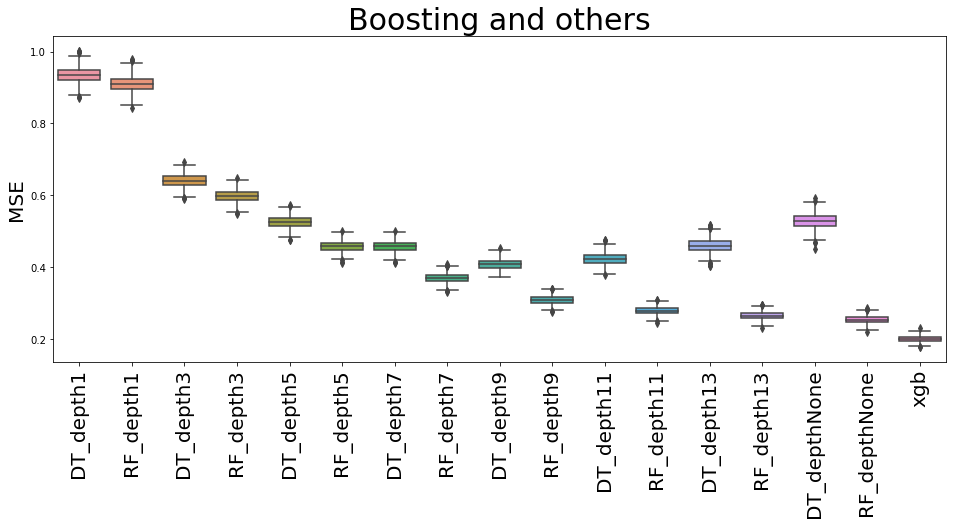

In [36]:
plt.figure(figsize=(16,6))
ax = sns.boxplot(data=pd.concat([results_depth, xgb_add]) , y="mse", x="model")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("Boosting and others", size=30)
plt.xticks(size=20)
plt.show()

### LightGBM

Он был изначально разработан для того, чтобы работать очень быстро. В него добавили много ухищрений, связанных с этим. Кроме этого, LightGBM по-умолчанию строит дерево немного иначе, нежели XGBoost.

XGBoost по-умолчанию строит дерево по уровням - на каждом уровне, если узел можно разбить так, чтобы улучшить значение функции ошибки, то мы это делаем. Ограничены мы только максимальной глубиной дерева. 

LightGBM же строит дерево по-узлам. На каждом шаге бьется тот узел, разбиение которого сильнее всего минимизирует функцию ошибки. И ограничения на глубину нет. В LightGBM вводится ограничение не на глубину дерева, а на общее число листьев в итоговом дереве. 

<img src ="http://edunet.kea.su/repo/src/L03_Classic_ML/img_license/L03_Classic_ML-71.png" width="800">

По-умолчанию он **еще** быстрее (хотя в xgboost тоже есть опции для ускорения)

Из-за особенностей построения им деревьев, надо задавать не высоту дерева, а максимальное число листьев. Поставим пока так, чтобы число листьев было равно числу листьев в дереве высоты 6:

In [37]:
import lightgbm

models_add3 = {}
models_add3["lightgbm"] = lightgbm.LGBMRegressor(n_estimators=2000, # Он быстрый, так что можно ставить много деревьев 
                     learning_rate=0.1,
                     max_depth=-1,
                     num_leaves=2**6,                     
                     random_state=42,
                     min_child_weight=7,
                     n_jobs=-1)

lgb_add = train_and_test_regressor(models_add3, X_train, y_train, X_test, y_test)

Fitting lightgbm
Calculating bootstrap score for lightgbm


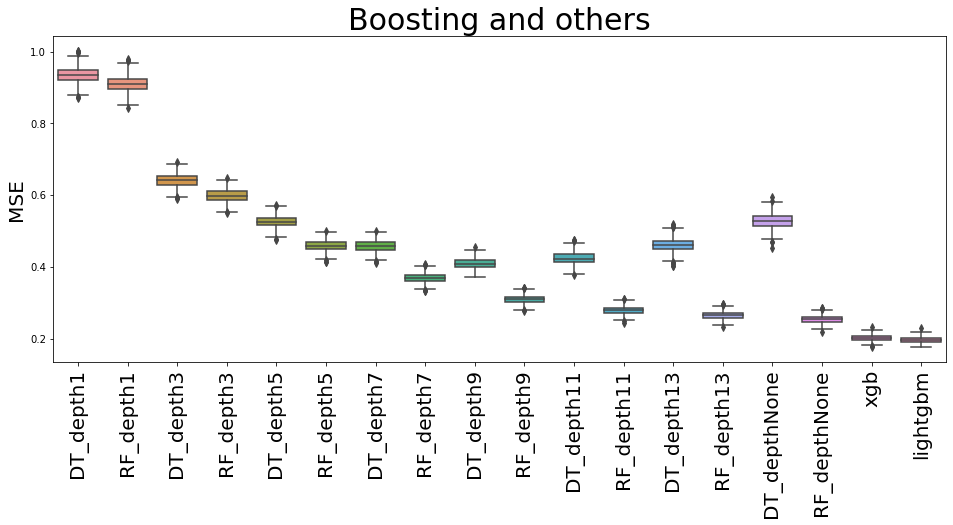

In [38]:
plt.figure(figsize=(16,6))
ax = sns.boxplot(data=pd.concat([results_depth, xgb_add, lgb_add]) , y="mse", x="model")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("Boosting and others", size=30)
plt.xticks(size=20)
plt.show()

### CatBoost

Разработал Яндекс.  

CatBoost:

1. хорошо умеет работать с категориальными признаками. Если у вас много категориальных признаков - он может дать сушественный выигрыш. 
2. по-умолчанию использует в качестве модели модификацию обычного дерева решения - Symmetric Tree - которое менее склонно к переобучению

In [39]:
!pip install catboost

You should consider upgrading via the '/home/daniil/.pyenv/versions/3.8.12/bin/python3.8 -m pip install --upgrade pip' command.


In [40]:
import catboost

models_add4 = {}
models_add4["catboost"] = catboost.CatBoostRegressor(iterations=2000, 
                     learning_rate=0.1,
                     depth=6,
                     random_state=42,
                     min_data_in_leaf=7,
                     verbose=0,
                     #cat_features=[list of categorial features])
                     #task_type="GPU") # Можно ускорять при помощи видеокарты
)

cat_add = train_and_test_regressor(models_add4, X_train, y_train, X_test, y_test)

Fitting catboost
Calculating bootstrap score for catboost


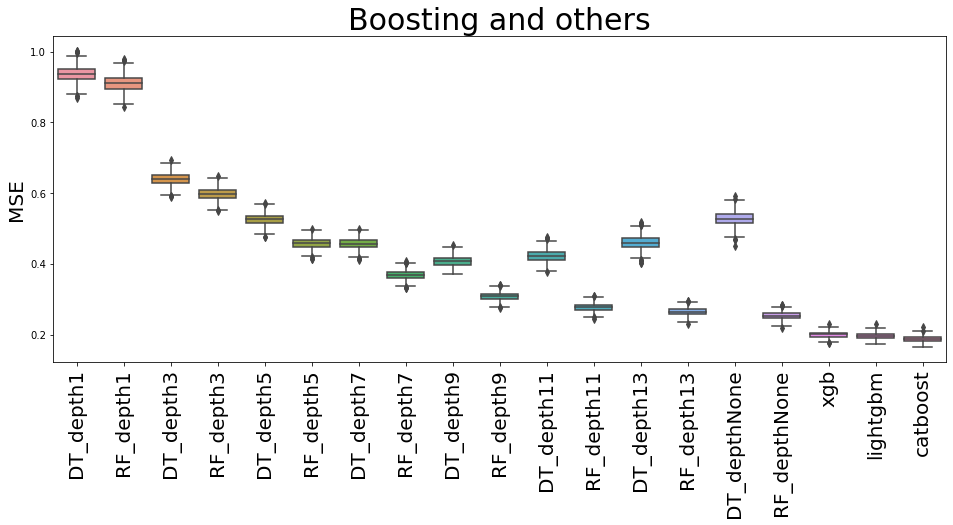

In [41]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(data=pd.concat([results_depth, xgb_add, lgb_add, cat_add]) , y="mse", x="model")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("Boosting and others", size=30)
plt.xticks(size=20)
plt.show()

### Про другие реализации случайного леса

В xgboost и lightgbm есть свои, более быстрые и иногда более эффективные реализации случайного леса. Но их надо дополнительно настраивать.

### Про подбор параметров модифицированных бустингов
Каждый из модифицированных бустингов имеет свои особые параметры и рекомендации от создателей и участников Kaggle, как и в каком порядке выбирать параметры для конкретного бустинга. Если вы решили использовать тот или иной вид бустинга в своей задача - ОЗНАКОМЬТЕСЬ c этими советами. 

Все три бустинга, к примеру, позволяют задавать не только число признаков, использующихся в каждом узле, но и число признаков, использующщихся в каждом дереве в целом. 

Кроме того, все три бустинга имеют настройки, ускоряющие их работу (у lightgbm эти настройки выставлены по-умолчанию) и все три бустинга умеют работать на GPU

Здесь мы бегло пробежались по самым верхам, копируя подобранные на предудущих этапах параметры.

### Blending (Блендинг)

На соревновании Netflix Prize была поставлена задача - предсказать , как люди оценят тот или иной фильм. 
Победил подход, основанный на таком объединении модели, при котором у вас каждая модель получает вес в зависимости от объекта. Подход называется **блендинг**.

<img src ="https://edunet.kea.su/repo/src/L03_Classic_ML/img/p/netflix.png" width="600">

У нас есть **обучающая и тестовая выборка**.

1. Бьем обучающую выборку на две подвыборки - A (побольше) и B

2. Обучаем набор базовых алгоритмов на подвыборке A. 

3. Получаем предсказания этих базовых алгоритмов на объектах из выборки B

4. Используем эти предсказания в качестве признаков для метаалгоритма, который будет предсказывать веса алгоритмов. Обучаем его на выборке B.

5. Для того, чтобы сделать предказание на тесте:
  1. Получаем предсказания базовых моделей на тесте
  2. Аггрегируем их при помощи метаалгоритма


Тестовую выборку не трогаем. Дополнительно **разбиваем обучение и обучаем алгоритмы на разбиении**, каждый алгоритм дает какое-то предсказание. На отложенной части обучения делаем то же предсказание, то есть используем предсказания алгоритмов как дополнительные признаки. Получается датасет, в котором есть изначальные признаки и предсказания моделей. Дальше можно **обучить мета-алгоритм либо на объединении всех этих признаков, либо только на этих признаках**. Получится, что алгоритм будет брать предсказания других алгоритмов, обрабатывать их внутри себя и выдавать итоговое предсказание. 
<img src ="https://edunet.kea.su/repo/src/L03_Classic_ML/img_license/blending.png" width="800">



Недостатком блендинга является то, что мы дополнительно разбиваем обучающую выборку - нельзя учить и базовые алгоритмы, и основной на одних и тех же данных. 

Для улучшения качество можно сделать несколько блендингов (по-разному разбивая обучающую выборку на выборки A и B), а дальше усреднять предсказания разных блендингов.

### Стэкинг

Концептуально все очень похоже на блендинг, только используем кросс-валидацию, чтобы не делить тренировочную выборку еще на 2.

Можете посмотреть пример реализации, например, [здесь](https://github.com/Dyakonov/ml_hacks/blob/master/dj_stacking.ipynb). В принципе, если вам действительно понадобится стэкинг, полезно иметь свою собственную реализацию, чтобы легко менять в ней некоторые детали (вариантов стекинга - великое множество)

# Ссылки на дополнительные материалы

## Про деревья решений<a class="anchor" style="autocontent" id="Про-деревья-решений"/><br>

[Деревья решений](https://www.kaggle.com/kashnitsky/topic-3-decision-trees-and-knn)


## Про ансамбли<a class="anchor" style="autocontent" id="Про-ансамбли"/><br>

[https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/](https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/)

[Цикл лекций по обучению ансамблей](https://medium.com/ml-research-lab/ensemble-learning-relation-with-bias-and-variance-431cdc0a3fc9)

[Про стэкинг и блендинг](https://dyakonov.org/2017/03/10/c%D1%82%D0%B5%D0%BA%D0%B8%D0%BD%D0%B3-stacking-%D0%B8-%D0%B1%D0%BB%D0%B5%D0%BD%D0%B4%D0%B8%D0%BD%D0%B3-blending/)


## XGBoost<a class="anchor" style="autocontent" id="XGBoost1"/><br>
[отличие XGBoost от обычного градиентного бустинга](https://stats.stackexchange.com/questions/202858/xgboost-loss-function-approximation-with-taylor-expansion)

[оригинальная статья](https://arxiv.org/pdf/1603.02754.pdf)

[как подбирать параметры xgboost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)


## CatBoost<a class="anchor" style="autocontent" id="CatBoost"/><br>

[Официальная документация](https://catboost.ai/docs/concepts/parameter-tuning.html#rand-str)

## LightGBM<a class="anchor" style="autocontent" id="LightGBM1"/><br>

[Очень подробная и удобная документация](https://lightgbm.readthedocs.io/en/latest/ )


[Описание параметров](https://neptune.ai/blog/lightgbm-parameters-guide?utm_source=datacamp&utm_medium=post&utm_campaign=blog-lightgbm-parameters-guide&utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com)

[Новый бустинг с деревьями, содержащими в листах линейные регрессии](https://arxiv.org/pdf/1802.05640.pdf)

## Дисбаланс классов<a class="anchor" style="autocontent" id="Дисбаланс-классоов"/><br>
[Обучение в случае дисбаланса классов](http://www.svds.com/learning-imbalanced-classes/)

[Bagging и случайные леса для обучения с имбалансом классов](https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/)

[Коэффициент корреляции Мэтьюса](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7)